In [1]:
import pandas as pd

import requests 
url = "https://www.kebhana.com/cms/rate/wpfxd651_01i_01.do"

payload = {"ajax" : "true",
            "curCd" : "",
            "pbldDvCd" : "0",
            "pbldSqn" : "",
            "hid_key_data" : "",
            "inqStrDt" : "20230307",
            "inqKindCd" : "1",
            "hid_enc_data" : "",
            "requestTarget" : "searchContentDiv",}

def get_exchange(date_, currency, type_=1):
    """
    date_ : 날짜, 날짜는 yyyy-mm-dd 형식으로 입력 
    currency: 화폐 코드 
    type_ : 0 사실때 , 1 파실때 
    """
    global hana
    payload['inqStrDt'] = date_.replace("-","")
    r  = requests.post(url, data=payload)
    hana = pd.read_html(r.text)[0]
    hana.columns = ["_".join(sorted(list(set(x)))) for x in hana.columns]
    if type_ == 0:
        return hana.loc[hana.통화.str.find(f"{currency}".upper()) > -1,  "사실 때_현찰_환율"].values[0]
    elif type_ == 1:
        return hana.loc[hana.통화.str.find(f"{currency}".upper()) > -1,  "파실 때_현찰_환율"].values[0]
    else:
        return -1

In [2]:
import pandas as pd

In [4]:
exchange = {x.strftime("%Y-%m-%d"):get_exchange(x.strftime("%Y-%m-%d"), 'usd') for x in pd.date_range("2020-01-01", '2023-03-06')}
    
    

In [10]:
import dbconnect
cur, con = dbconnect.connection(host="encore.cluster-cd9ecw5piy57.ap-northeast-2.rds.amazonaws.com",
                     user='admin', password='newjeans', db='encore')

In [11]:
sql = "INSERT INTO exchange VALUES (%s, %s, %s, %s)"

In [13]:
for key, val in exchange.items():
    cur.execute(sql, [key, val, 'USD', 1])
con.commit()

In [16]:
df = pd.read_sql_query("""SELECT * FROM exchange
WHERE ex_date > '2021-01-01' 
AND currency = 'usd'
AND sanda_panda = 1""", con)

C:\Users\encore\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## 코스피 지수 

In [29]:
naver_url = "https://finance.naver.com/sise/sise_index_day.naver?code=KOSPI&page={}"
head = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36'}
kospi = pd.concat([pd.read_html(requests.get(naver_url.format(x), headers=head).text)[0].dropna() for x in range(1, 101)])
kospi = kospi.iloc[::-1]
kospi.날짜 = pd.to_datetime(kospi.날짜)
kospi2 = kospi.query("날짜 >= '2021-01-01'").copy()

In [20]:
from matplotlib import font_manager, rc
font_path = "./font/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family=font_name)

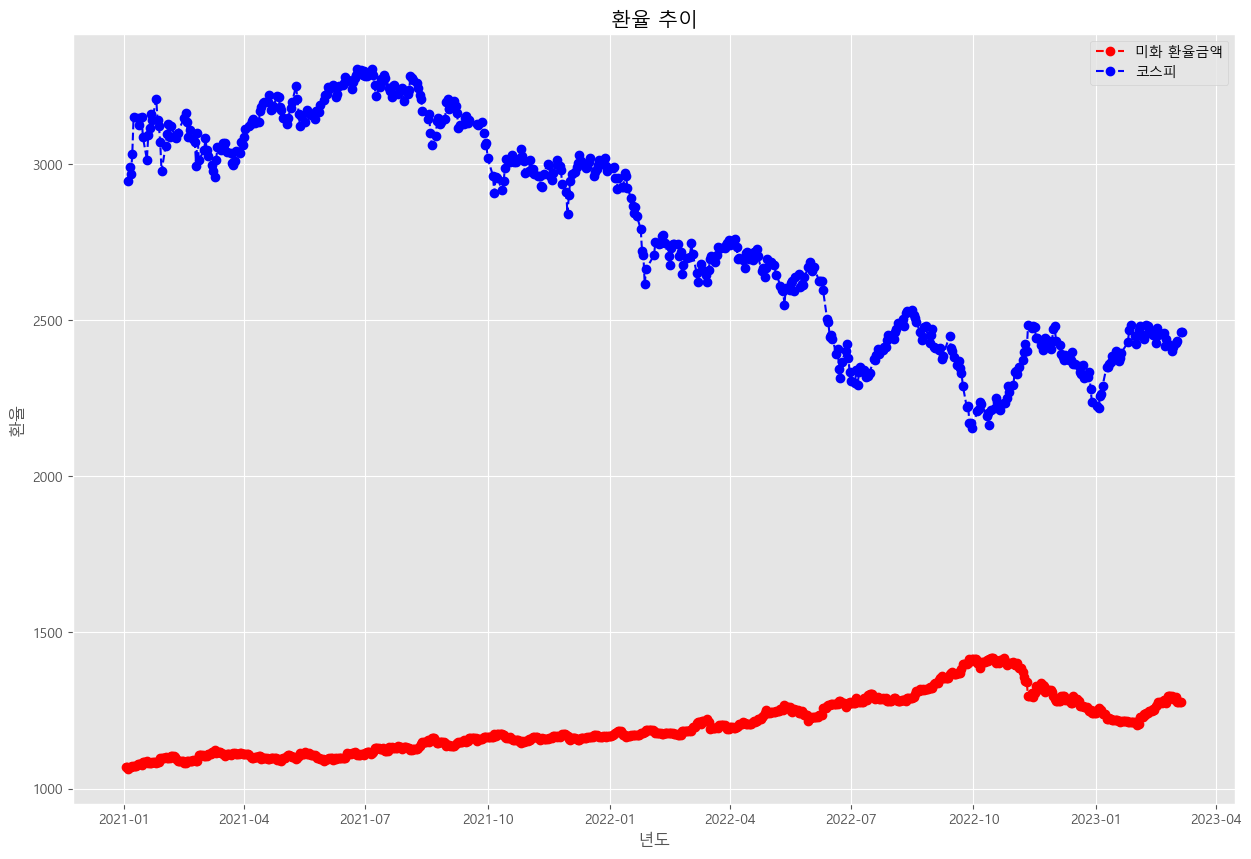

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.style.use("ggplot")
x_value_01 = df.ex_date
y_value_01 = df.ex_rate

# 마커를 포함한 빨간선 대쉬 선 그래프를 그리고, label은 'red line'으로 설정  
plt.plot(x_value_01, y_value_01, color='red', marker='o', linestyle='dashed', label='미화 환율금액')
# X값에 따른 Y값을 나타내는 초록색 막대 그래프를 그리고 label은 'bar plot'으로 설정
plt.plot(kospi2.날짜, kospi2.체결가, color='blue', marker='o', linestyle='dashed', label='코스피')
plt.xlabel('년도')
plt.ylabel('환율')
# 두개의 그래프에서 label설정된 문자열 값을 범례로 표시
#plt.xticks(ticks=x_value_01, rotation=45)
plt.legend()

plt.title('환율 추이')

plt.show()